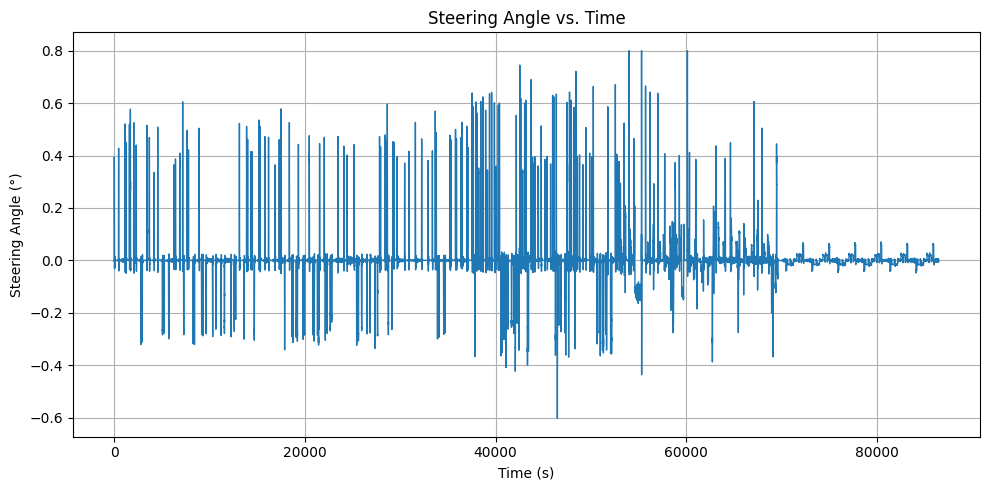

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# ——— CONFIG ———
csv_path = '/Users/yashraj/Library/CloudStorage/OneDrive-TechnischeHochschuleIngolstadt/THI/Academics/Sem 4/Summer Project/LLM-based Agent for Driver Sleepiness Detection and Mitigation in Automotive Systems/Feature_extraction/LLM-based-AI-Agent-for-Driver-sleepiness-detection-and-mitigation/Steering/steer_values.csv'  # e.g. '/home/user/data/steer.csv'
sampling_rate = 1  # samples per second (e.g. 10 for 10 Hz)
# ————————

# Load CSV (no header assumed; single column of steering angles)
df = pd.read_csv(csv_path, header=None, names=['steering_angle'])

# Create time axis in seconds from sample index
time_s = df.index / sampling_rate

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_s, df['steering_angle'], linewidth=1)
plt.xlabel('Time (s)')
plt.ylabel('Steering Angle (°)')
plt.title('Steering Angle vs. Time')
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import numpy as np
import pandas as pd
from scipy.stats import iqr

# --- CONFIGURATION -----------------------------------
csv_path     = '/Users/yashraj/Library/CloudStorage/OneDrive-TechnischeHochschuleIngolstadt/THI/Academics/Sem 4/Summer Project/LLM-based Agent for Driver Sleepiness Detection and Mitigation in Automotive Systems/Feature_extraction/LLM-based-AI-Agent-for-Driver-sleepiness-detection-and-mitigation/Steering/steer_values.csv'  # single-column CSV of angles (degrees)
sampling_rate = 20   # e.g. 10 Hz if CARLA recorded 10 samples/sec
window_sec    = 30   # length of sliding window in seconds
step_sec      = 5    # window step in seconds
# ----------------------------------------------------

# 1. Load your steering data
df = pd.read_csv(csv_path, header=None, names=['angle'])
angles = df['angle'].values.astype(float)

# 2. Define feature computations
def sample_entropy(x, m=2, r=None):
    x = np.asarray(x)
    N = len(x)
    if r is None:
        r = 0.2 * np.std(x)
    def _phi(m):
        C = 0
        for i in range(N - m):
            template = x[i : i + m]
            for j in range(i + 1, N - m):
                if np.max(np.abs(template - x[j : j + m])) <= r:
                    C += 1
        return C
    return -np.log(_phi(m+1) / _phi(m))

def reversal_rate(x, sr):
    diffs = np.diff(x)
    signs = np.sign(diffs)
    rev = np.sum(signs[:-1] * signs[1:] < 0)
    return rev / (len(x) / sr)

def variability(x):
    return np.std(x), iqr(x)

# 3. Slide a window over the data and compute features
win_n = window_sec * sampling_rate
step_n = step_sec * sampling_rate

feature_rows = []
for start in range(0, len(angles) - win_n + 1, step_n):
    win = angles[start : start + win_n]
    ent  = sample_entropy(win)
    rev  = reversal_rate(win, sampling_rate)
    std_, iqr_ = variability(win)
    feature_rows.append({
        'start_time_s': start / sampling_rate,
        'sampen':      ent,
        'rev_rate':    rev,
        'std':         std_,
        'iqr':         iqr_
    })

feat_df = pd.DataFrame(feature_rows)

# 4. Simple rule-based drowsiness flag
#    (e.g. low entropy + low reversal rate ⇒ drowsy)
feat_df['drowsy_flag'] = (
    (feat_df['sampen']  < feat_df['sampen'].median()) &
    (feat_df['rev_rate'] < feat_df['rev_rate'].median())
).astype(int)

# 5. Inspect your features
print(feat_df.head(10))
# You can also save to CSV:
feat_df.to_csv('steering_fatigue_features.csv', index=False)


   start_time_s    sampen  rev_rate       std       iqr  drowsy_flag
0           0.0  0.017921  6.266667  0.095796  0.002632            1
1           5.0  0.007473  6.033333  0.070889  0.001621            1
2          10.0  0.007473  6.233333  0.070883  0.002362            1
3          15.0  0.007457  6.333333  0.070912  0.003795            1
4          20.0  0.007515  6.433333  0.070930  0.005431            1
5          25.0  0.243348  6.166667  0.003687  0.005722            0
6          30.0  0.008653  6.700000  0.076666  0.006598            1
7          35.0  0.018103  6.900000  0.102287  0.008719            1
8          40.0  0.018970  6.766667  0.102220  0.009004            1
9          45.0  0.019905  6.433333  0.102218  0.007479            1


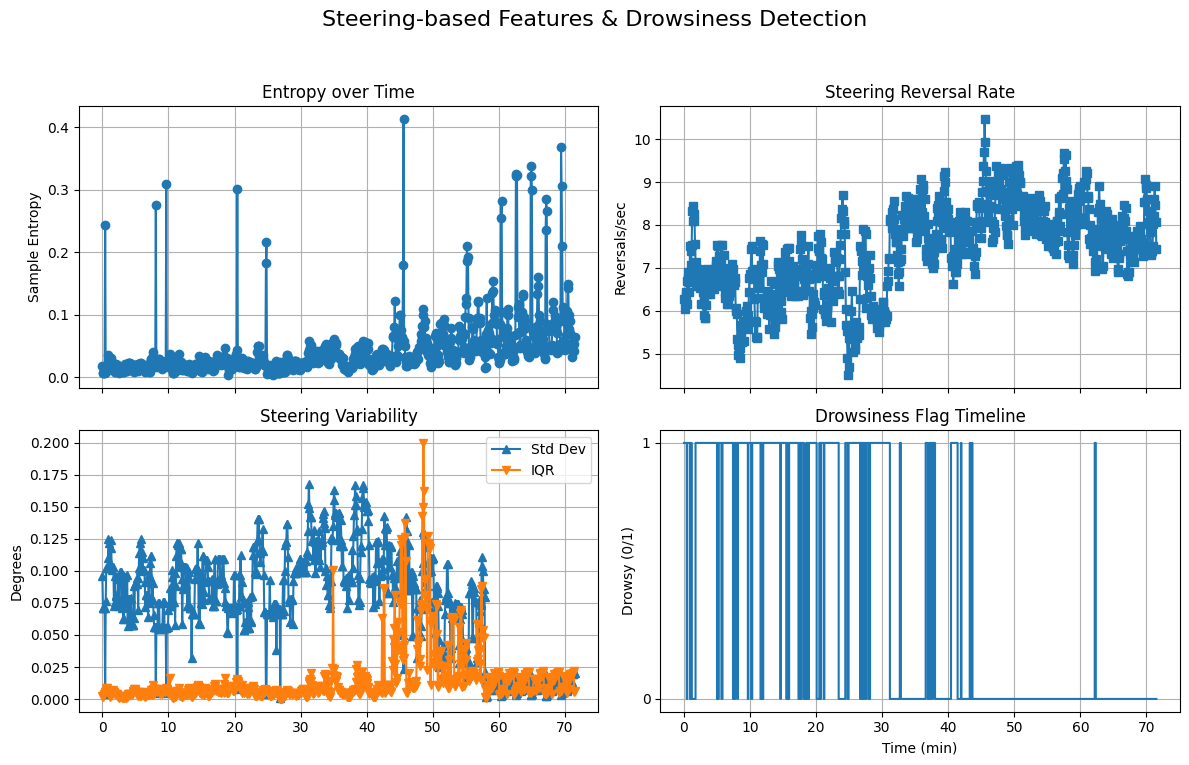

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ——— CONFIG ———
# If you already have feat_df in memory, skip loading.
# Otherwise, load the features CSV you generated:
# feat_df = pd.read_csv('steering_fatigue_features.csv')
# —————————————————

# Example: assume feat_df is already defined with columns
# ['start_time_s','sampen','rev_rate','std','iqr','drowsy_flag']

# Create time axis in minutes (or seconds) for readability
t = feat_df['start_time_s'] / 60  # in minutes

fig, axs = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# 1. Sample Entropy
axs[0,0].plot(t, feat_df['sampen'], marker='o', linestyle='-')
axs[0,0].set_ylabel('Sample Entropy')
axs[0,0].set_title('Entropy over Time')
axs[0,0].grid(True)

# 2. Reversal Rate
axs[0,1].plot(t, feat_df['rev_rate'], marker='s', linestyle='-')
axs[0,1].set_ylabel('Reversals/sec')
axs[0,1].set_title('Steering Reversal Rate')
axs[0,1].grid(True)

# 3. Variability (Std & IQR)
axs[1,0].plot(t, feat_df['std'], label='Std Dev', marker='^')
axs[1,0].plot(t, feat_df['iqr'], label='IQR', marker='v')
axs[1,0].set_ylabel('Degrees')
axs[1,0].set_title('Steering Variability')
axs[1,0].legend()
axs[1,0].grid(True)

# 4. Drowsy Flag
axs[1,1].step(t, feat_df['drowsy_flag'], where='post')
axs[1,1].set_ylabel('Drowsy (0/1)')
axs[1,1].set_xlabel('Time (min)')
axs[1,1].set_title('Drowsiness Flag Timeline')
axs[1,1].set_yticks([0,1])
axs[1,1].grid(True)

plt.suptitle('Steering-based Features & Drowsiness Detection', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
